## Setup

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt

# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [2]:
 # Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [3]:
# Declare a Base using `automap_base()`
Base = automap_base() 

In [4]:
 # Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [5]:
 # Assign the measuremens and stations classes to variables called `Measaurement` and `Station`
Measurement = Base.classes.measurements
Station = Base.classes.stations

In [6]:
 session = Session(engine)

## Choose Vacation Dates

In [7]:
# Set Vacation Dates 7/2-7/15

## Explore Data

In [8]:
# review measurements data
engine.execute('SELECT * FROM measurements LIMIT 5').fetchall()

[(0, 'USC00519397', '2010-01-01', 0.08, 65),
 (1, 'USC00519397', '2010-01-02', 0.0, 63),
 (2, 'USC00519397', '2010-01-03', 0.0, 74),
 (3, 'USC00519397', '2010-01-04', 0.0, 76),
 (4, 'USC00519397', '2010-01-07', 0.06, 70)]

In [9]:
# review stations data
engine.execute('SELECT * FROM stations LIMIT 5').fetchall()

[('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [10]:
# review column and datatype
ins = inspect(engine)
columns = ins.get_columns('measurements')
for c in columns:
    print(c['name'], c["type"])

index INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs INTEGER


In [11]:
# review column and datatype
ins = inspect(engine)
columns = ins.get_columns('stations')
for c in columns:
    print(c['name'], c["type"])

station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


## Precipitation Analysis

In [12]:
# Design a query to pull date and prcp values for the last 12 months of precipitation data
# the lastest date 8/23/2017 as such the last 12 month is from 8-24-2016 to 8-23-2017
YearBeg = dt.datetime(2016,8,23) #set one less date before the year beg date 8/24
YearEnd = dt.datetime(2017,8,24) #set one more date after the year end date 8/23

results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > YearBeg).filter(Measurement.date < YearEnd).all()

In [13]:
 # Unpack the `dates` and `prcp` from results and save into separate lists
OneYearDates = [r[0] for r in results]
OneYearPrcp = [r[1] for r in results]

In [14]:
# Save data in dataframe and set `date` as index
PrcpbyD = pd.DataFrame({'date':OneYearDates,'precipitation':OneYearPrcp})
PrcpbyD.set_index('date',inplace=True)
PrcpbyD.head()

,precipitation
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


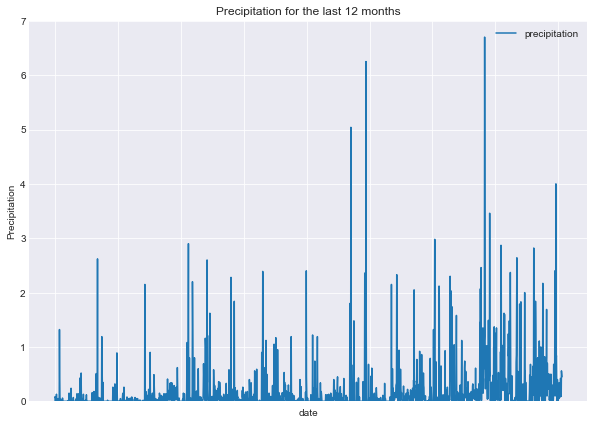

In [15]:
#Plot the results using the DataFrame plot method.
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
sns.set_style(style="darkgrid")
fig, ax = plt.subplots(figsize=(10,7))
PrcpbyD.plot(ax=ax)

#set major ticks format
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.set_ylim(0,max(PrcpbyD['precipitation']+.3))
ax.set_title("Precipitation for the last 12 months")
ax.set_ylabel("Precipitation")
ax.set_xlabel("date")
plt.xticks(rotation=45)
plt.savefig("Homework_Images/Precipitation_last_12_months.png")
plt.show()

In [16]:
#Use Pandas to print the summary statistics for the precipitation data
PrcpbyD.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [17]:
#Design a query to calculate the total number of stations.
NumStation = session.query(Measurement).group_by(Measurement.station).count()
#double check using Stations table
NumStation1 = session.query(Station).group_by(Station.station).count()
print(f"{NumStation} stations from Measurement table and {NumStation1} stations from Station table")

9 stations from Measurement table and 9 stations from Station table


In [18]:
#Design a query to find the most active stations.
#List the stations and observation counts in descending order
#Which station has the highest number of observations?
#Use Pandas `read_sql_query` to load a query statement directly into the DataFrame
Active = session.query(Measurement.station, Station.name, func.count(Measurement.index)).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.index).desc()).statement

#write into DataFrame
dfActive = pd.read_sql_query(Active, session.bind)

#Most Active Stations Number
ASNum = dfActive["station"][0]
#Most Active Stations Name
AS = dfActive['name'][0]
#highest number of observation
ASC = dfActive['count_1'][0]

print(f"Station #{ASNum}-'{AS}' has the highest number of observations: {ASC}.")

# List the full list of stations
dfActive

Station #USC00519281-'WAIHEE 837.5, HI US' has the highest number of observations: 2772.


,station,name,count_1
0,USC00519281,"WAIHEE 837.5, HI US",2772
1,USC00513117,"KANEOHE 838.1, HI US",2696
2,USC00519397,"WAIKIKI 717.2, HI US",2685
3,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2572
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",2484
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",1937
6,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1932
7,USC00517948,"PEARL CITY, HI US",683
8,USC00518838,"UPPER WAHIAWA 874.3, HI US",342


In [19]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
## the lastest date 8/23/2017 as such the last 12 month is from 8-24-2016 to 8-23-2017 it has been defined previously
## Filter by the station with the highest number of observations.

GetTemp = session.query(Measurement.tobs).\
    filter(Measurement.date > YearBeg).filter(Measurement.date < YearEnd).\
    filter(Measurement.station == ASNum).statement

TempData = pd.read_sql_query(GetTemp, session.bind)
TempData.head()

,tobs
0,77
1,80
2,80
3,75
4,73


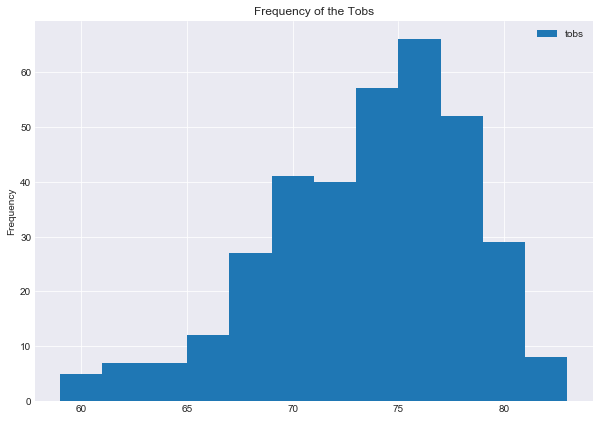

In [20]:
## Plot the results as a histogram with bins=12.
sns.set_style(style="darkgrid")
ax = TempData.plot(kind="hist",bins=12,figsize=(10,7))

ax.set_title("Frequency of the Tobs")
ax.set_ylabel("Frequency")
plt.savefig("Homework_Images/Frequency_of_the_tobs.png")
plt.show()

## Temperature Analysis

In [21]:
#Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d 
##and return the minimum, average, and maximum temperatures for that range of dates.
#Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates
# Previourly choosen Vacation Dates 7/2-7/15
VacaBeg = dt.datetime(2017,7,1) #set one less date before the year beg date 7/2
VacaEnd = dt.datetime(2017,7,15) #set one less date before the year beg date 7/15

calc_temp = session.query(func.avg(Measurement.tobs),func.max(Measurement.tobs),func.min(Measurement.tobs)).\
    filter(Measurement.date > VacaBeg).filter(Measurement.date < VacaEnd).statement
#write into a dataframe
TempStat = pd.read_sql_query(calc_temp, session.bind)
TempStat

,avg_1,max_1,min_1
0,77.946667,82,69


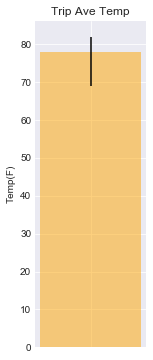

In [22]:
# Plot the min, avg, and max temperature from your previous query as a bar chart.
## Use the average temperature as the bar height.
## Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

TAve = TempStat['avg_1']
TMax = TempStat['max_1']
TMin = TempStat['min_1']
 
x = np.arange(1,2)
sns.set_style(style="darkgrid")
width =0.1
plt.figure(figsize=(2,6))
plt.bar(x,TAve,width,linewidth=10,alpha=0.5, tick_label="", color="orange",yerr=(TAve-TMin,TMax-TAve))

plt.title("Trip Ave Temp")

plt.ylabel("Temp(F)")
plt.savefig("Homework_Images/Trip_Ave_Temp.png")
plt.show()
